# Loading packages

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.preprocessing import sequence, text
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping
from keras import initializers
#from keras.datasets import imdb

from google.colab import files

# Data preprocessing

In [3]:
data = files.upload()

Saving feedback.csv to feedback.csv


In [0]:
df = pd.read_csv('feedback.csv', sep=',', names=['rating','product_id','name','date','feedback1', 'feedback2','feedback3'], skiprows=1)

In [0]:
feedbacks = ['feedback1', 'feedback2', 'feedback3']
for column in feedbacks:
  df[column].replace(np.nan, '', inplace=True)

In [0]:
df['full_feedback']= df.feedback1 + ' ' + df.feedback2 + ' ' + df.feedback3

In [0]:
df.drop(columns=feedbacks, inplace=True)

In [0]:
df.rating = np.round(df.rating) #as was shown in eda there are only about 200 observations which values deviate from integer

In [18]:
df.head()

,rating,product_id,name,date,full_feedback
0,1.0,8342,Александр,2017-04-12,"6 входов, предохранитель искрит при включении ..."
1,5.0,8342,Елена,2015-08-04,Я являюсь пользователем Пилотов уже больше 10 ...
2,5.0,5311,Леонид,2017-07-16,"хорошо мелет маркий, остаются следы Использую ..."
3,4.0,5311,Сергей,2017-06-28,Компактная Не нашел Работает на ура. В инструк...
4,5.0,5311,Ольга,2017-01-21,Цена и качество Нет В использовании 2 месяца п...


In [0]:
vocab_length = 10000
tokenizer = text.Tokenizer(num_words=vocab_length)

In [0]:
tokenizer.fit_on_texts(df.full_feedback)

In [0]:
sequences = tokenizer.texts_to_sequences(df.full_feedback)

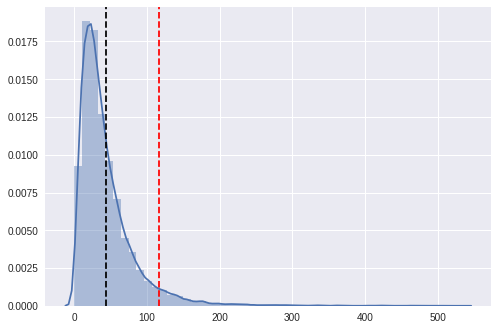

117.0


In [11]:
sns.distplot(list(map(len, sequences)))
plt.axvline(np.mean(list(map(len, sequences))), color="k", linestyle="--")
plt.axvline(np.percentile(list(map(len, sequences)), 95), color="red", linestyle="--")
plt.show()
print(np.percentile(list(map(len, sequences)), 95))

The red line on the graph above shows the length of feedbacks (129) that covers 95% of all observations

In [12]:
print( np.var(df.rating) )
print( np.std(df.rating) )

1.7209728589242392
1.3118585514163634


In [0]:
most_length = 117
padded_seq = sequence.pad_sequences(sequences, maxlen=most_length)

## Train-validation-test split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(padded_seq, df.rating, random_state=42)

In [0]:
#y_train = pd.get_dummies(y_train)
#y_test = pd.get_dummies(y_test)

# Model building

## RNN

In [41]:
#dont forget to add random weights initialization
model = Sequential()
model.add(Embedding(vocab_length, 117, input_length=most_length))
model.add(Bidirectional(LSTM(64, activation='tanh')))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu', kernel_initializer='glorot_uniform'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'mean_squared_error', metrics=['mse'])

model.fit(X_train, y_train, batch_size=50, epochs=5,
          validation_data=[X_test, y_test], callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.1, patience=0)])

Train on 13756 samples, validate on 4586 samples
Epoch 1/5
13756/13756 [==============================] - 94s 7ms/step - loss: 2.4085 - mean_squared_error: 2.4085 - val_loss: 1.1208 - val_mean_squared_error: 1.1208
Epoch 2/5
13756/13756 [==============================] - 93s 7ms/step - loss: 0.9465 - mean_squared_error: 0.9465 - val_loss: 0.9051 - val_mean_squared_error: 0.9051
Epoch 3/5
13756/13756 [==============================] - 93s 7ms/step - loss: 0.6690 - mean_squared_error: 0.6690 - val_loss: 0.9378 - val_mean_squared_error: 0.9378


## "Fasttext"

In [0]:
def create_ngram_set(input_list, ngram_value=2):
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


In [0]:
def add_ngram(sequences, token_indice, ngram_range=2):
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [0]:
ngram_range = 2
ngram_set = set()
for input_list in sequences:
  for i in range(2, ngram_range + 1):
    set_of_ngram = create_ngram_set(input_list, ngram_value=i)
    ngram_set.update(set_of_ngram)
start_index =  1 #to build only on ngrams
token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
indice_token = {token_indice[k]: k for k in token_indice}

In [0]:
max_features = np.max(list(indice_token.keys())) + 1

In [0]:
gram_sequences = add_ngram(sequences, token_indice, ngram_range)

In [0]:
padded_gram_seq = sequence.pad_sequences(gram_sequences, maxlen=128) #increasing len as we add ngrams to sequences

In [0]:
X_train, X_test, y_train, y_test = train_test_split(padded_gram_seq, df.rating, random_state=42)

In [0]:
model = Sequential()
model.add(Embedding(max_features,
                    128,
                    input_length=128, embeddings_initializer=initializers.RandomNormal(mean=0.0, stddev=0.05)))
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mse'])
model.fit(X_train, y_train,
          batch_size=50,
          epochs=10,
          validation_data=(X_test, y_test), callbacks=EarlyStopping(monitor='val_loss', min_delta=0.1, patience=0))

## Embeddings